In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from lightgbm import LGBMClassifier


from matplotlib import ticker
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [3]:
# Reduce Memory Usage
# reference : https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 @ARJANGROEN

def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [7]:
train_df = pd.read_csv('data/train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13174211 entries, 0 to 13174210
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      int64  
 1   index           int64  
 2   elapsed_time    int64  
 3   event_name      object 
 4   name            object 
 5   level           int64  
 6   page            float64
 7   room_coor_x     float64
 8   room_coor_y     float64
 9   screen_coor_x   float64
 10  screen_coor_y   float64
 11  hover_duration  float64
 12  text            object 
 13  fqid            object 
 14  room_fqid       object 
 15  text_fqid       object 
 16  fullscreen      float64
 17  hq              float64
 18  music           float64
 19  level_group     object 
dtypes: float64(9), int64(4), object(7)
memory usage: 2.0+ GB


In [8]:
train_df = reduce_memory_usage(train_df)
train_df.info()

Memory usage of dataframe is 2010.23 MB
Memory usage became:  778.9939136505127  MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13174211 entries, 0 to 13174210
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int16   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           int8    
 6   page            float16 
 7   room_coor_x     float16 
 8   room_coor_y     float16 
 9   screen_coor_x   float16 
 10  screen_coor_y   float16 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      float64 
 17  hq              float64 
 18  music           float64 
 19  level_group     category
dtypes: category(7), float16(5), float32(1), float64(3), int16(1), int32(1), int64(1), int8(1)
memory usage: 779.0 MB


In [9]:
import gc
gc.collect()

1170

In [10]:
train_label = pd.read_csv('data/train_labels.csv')
train_label = reduce_memory_usage(train_label)
train_label['session'] = train_label.session_id.apply(lambda x: int(x.split('_')[0]) )
train_label['q'] = train_label.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( 'shape of label dataset is:',train_label.shape )

Memory usage of dataframe is 3.24 MB
Memory usage became:  10.691259384155273  MB
shape of label dataset is: (212022, 4)


In [11]:
train_label.head()

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


In [12]:
gc.collect()

0

In [13]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [14]:
summary_table = summary(train_df)
summary_table

data shape: (13174211, 20)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
session_id,int64,0,0.000000,11779,20090312431273200.0,22100221145014656.0,20090312431273200,20090312431273200,20090312431273200
index,int16,0,0.000000,20348,0.0,20473.0,0,1,2
elapsed_time,int32,0,0.000000,3804019,0.0,1749293395.0,0,1323,831
event_name,category,0,0.000000,11,NaN,NaN,cutscene_click,person_click,person_click
name,category,0,0.000000,6,NaN,NaN,basic,basic,basic
level,int8,0,0.000000,23,0.0,22.0,0,0,0
page,float16,1288946500,0.978386,7,0.0,6.0,NaN,NaN,NaN
room_coor_x,float16,103624000,0.078657,28082,-1992.0,1262.0,-414.0,-414.0,-414.0
room_coor_y,float16,103624000,0.078657,25809,-918.0,543.5,-159.375,-159.375,-159.375
screen_coor_x,float16,103624000,0.078657,6266,0.0,1916.0,380.0,380.0,380.0


In [15]:

just_dummies = pd.get_dummies(train_df['event_name'])

train_df = pd.concat([train_df, just_dummies], axis=1)
train_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,cutscene_click,map_click,map_hover,navigate_click,notebook_click,notification_click,object_click,object_hover,observation_click,person_click
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,...,1,0,0,0,0,0,0,0,0,0
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,0,0,0,0,0,1
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,0,0,0,0,0,1
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,0,0,0,0,0,1
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
train_df['event_name'].value_counts()

navigate_click        5687896
person_click          3024847
cutscene_click        1351732
object_click          1099670
object_hover           529116
map_hover              471621
notification_click     324106
notebook_click         284746
map_click              258714
observation_click      106260
checkpoint              35503
Name: event_name, dtype: int64

In [17]:
count_var = ['event_name', 'fqid','room_fqid', 'text']
mean_var = ['elapsed_time','level']
event_var = ['navigate_click','person_click','cutscene_click','object_click','map_hover','notification_click',
            'map_click','observation_click','checkpoint','elapsed_time']

In [18]:
# reference: https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook
def feature_engineer(train):
    dfs = []
    for c in count_var:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in mean_var:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in event_var:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [19]:
df_tr = feature_engineer(train_df)
print( df_tr.shape )

(35337, 17)


In [20]:
df_tr.head()

,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time,level,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,81,22,28,11,4,8,2,4,1,14155937
20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,170,123,60,20,14,10,6,3,1,437052322
20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,103,104,12,28,9,9,8,1,1,105732736
20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,49,18,36,15,3,5,3,2,1,13571045
20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,637,145,65,83,186,14,45,5,1,3241011333


In [21]:
gc.collect()

0

In [22]:
#check data type
df_tr.dtypes

level_group               category
event_name_nunique           int64
fqid_nunique                 int64
room_fqid_nunique            int64
text_nunique                 int64
elapsed_time               float64
level                      float64
navigate_click_sum          uint64
person_click_sum            uint64
cutscene_click_sum          uint64
object_click_sum            uint64
map_hover_sum               uint64
notification_click_sum       uint8
map_click_sum               uint64
observation_click_sum        uint8
checkpoint_sum               uint8
elapsed_time_sum             int64
dtype: object

In [23]:
FEATURES = [c for c in df_tr.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df_tr.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 16 features
We will train with 11779 users info


In [24]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df_tr, groups=df_tr.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    
    lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.002,
    'max_depth': 6,
    'num_iterations': 1000}
    
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df_tr.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = train_label.loc[train_label.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df_tr.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = train_label.loc[train_label.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        clf =  LGBMClassifier(**lgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 2
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 3
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 4
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 5
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 


In [25]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = train_label.loc[train_label.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [26]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

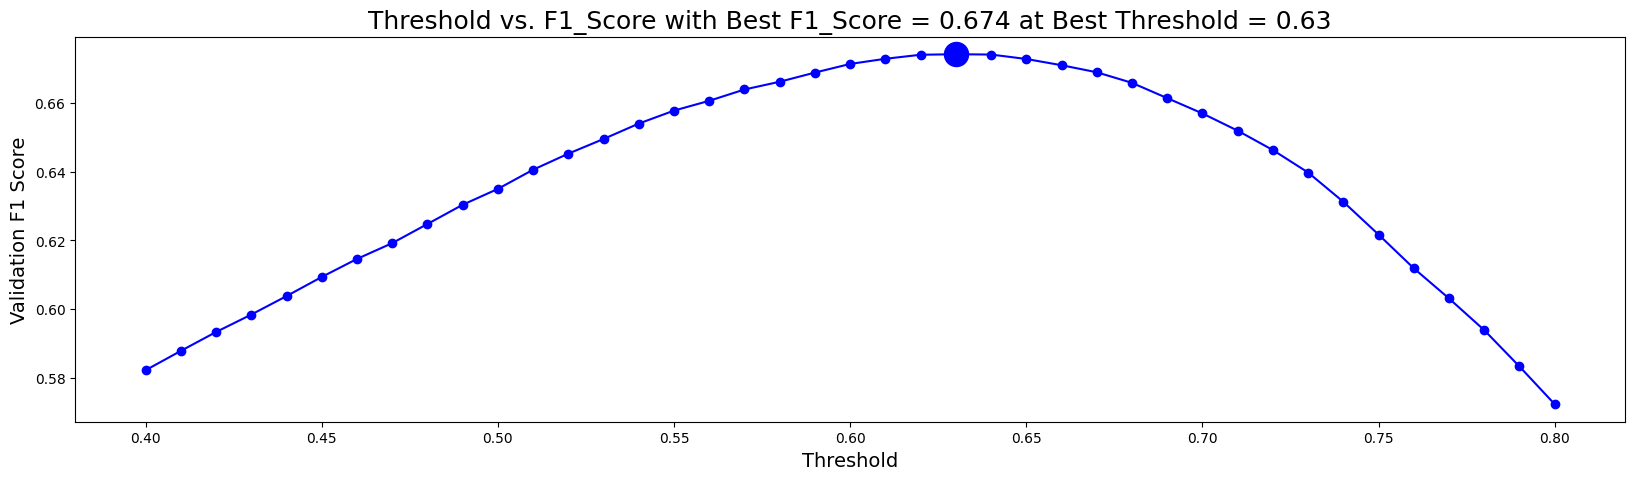

In [27]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [28]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5789572750475794
Q1: F1 = 0.49864232092097566
Q2: F1 = 0.4848823975979688
Q3: F1 = 0.5803516396106579
Q4: F1 = 0.54416947764779
Q5: F1 = 0.5905157777412786
Q6: F1 = 0.5843819076070677
Q7: F1 = 0.5332918554255237
Q8: F1 = 0.5901680091619177
Q9: F1 = 0.45291797320433214
Q10: F1 = 0.5884499841346579
Q11: F1 = 0.4939431735545562
Q12: F1 = 0.42338825978340106
Q13: F1 = 0.5991845747738016
Q14: F1 = 0.4463781869898538
Q15: F1 = 0.4541072048005406
Q16: F1 = 0.5244494275997651
Q17: F1 = 0.4937401234181795
==> Overall F1 = 0.6743135372138913
